In [231]:
import os
import pickle
import argparse
import matplotlib
import numpy as np
import pandas as pd

from operator import itemgetter
from sklearn.metrics.pairwise import cosine_similarity

In [232]:
data_dir = 'data'
lan = 'en' # 'en', 'it', 'de'
wsd_dir = 'WS353'

In [233]:
# Word similarity dataset WS353
lan_to_file = {'de': 'German', 'en': 'English', 'it': 'Italian'}
print(os.path.join('6', wsd_dir, f'MWS353_{lan_to_file[lan]}.txt'))
sim_ds = pd.read_csv(os.path.join('6', wsd_dir, f'MWS353_{lan_to_file[lan]}.txt'), sep=",")
sim_ds

6/WS353/MWS353_English.txt


,Word1,Word2,1,2,3,4,5,6,7,8,9,10,11,12,13,Average Score
0,love,sex,9.0,9.0,7.0,7.0,8,10.0,9.0,7.0,10.0,8.00,9.00,8.0,7,8.31
1,tiger,cat,7.0,9.0,9.0,7.0,8,7.0,10.0,7.0,10.0,8.00,9.00,8.0,9,8.31
2,tiger,tiger,10.0,10.0,10.0,10.0,10,10.0,10.0,10.0,10.0,10.00,10.00,10.0,10,10.00
3,book,paper,9.0,8.0,7.0,6.0,6,9.0,8.0,7.0,10.0,5.00,9.00,7.0,9,7.69
4,computer,keyboard,9.0,10.0,5.0,7.0,8,8.0,9.0,10.0,10.0,7.00,9.00,9.0,8,8.38
5,computer,internet,8.0,9.0,4.0,6.0,8,10.0,10.0,10.0,10.0,7.00,9.00,8.0,8,8.23
6,plane,car,7.0,9.0,5.0,5.0,5,8.0,6.0,5.0,6.0,8.00,2.00,5.0,5,5.85
7,train,car,7.0,8.0,6.0,6.0,5,8.0,8.0,6.0,7.0,8.00,2.00,5.0,6,6.31
8,telephone,communication,9.0,9.0,7.0,7.0,8,9.0,10.0,9.0,10.0,8.00,7.00,9.0,7,8.38
9,television,radio,8.0,8.0,6.0,6.0,5,9.0,7.0,8.0,8.0,8.00,5.00,5.0,6,6.85


In [234]:
# dictionary = { word: index }
word2idx = pickle.load(open(os.path.join(data_dir, lan, 'word2idx.dat'), 'rb'))
# ndarray ( vocabulary_size x embedding_size ). Row i = embedding WITHOUT SUBWORDS' INFO of word with index i.
idx2vec = pickle.load(open(os.path.join(data_dir, lan, 'idx2vec.dat'), 'rb'))
# ndarray ( vocabulary_size x embedding_size ). Row i = embedding WITH SUBWORDS' INFO of word with index i.
idx2vec_ngrams = pickle.load(open(os.path.join(data_dir, lan, 'idx2vec_ngrams.dat'), 'rb'))

In [235]:
idx2vec = np.concatenate((idx2vec, np.zeros((1,300))), axis = 0)
idx2vec_ngrams = np.concatenate((idx2vec_ngrams, np.zeros((1,300))), axis = 0)

In [236]:
# Number of words in common between our datests
ws353 = sim_ds
sim_words = set(ws353.Word1.values).union(set(ws353.Word2.values))
train_words = set(word2idx.keys())
common_words = [w for w in sim_words if w in train_words]
print(f"There are {len(common_words)} words in common")
common_words

There are 335 words in common


['issue',
 'nature',
 'software',
 'delay',
 'information',
 'competition',
 'stove',
 'fruit',
 'lawyer',
 'archive',
 'computer',
 'ticket',
 'man',
 'airport',
 'Japanese',
 'eye',
 'category',
 'secretary',
 'direction',
 'challenge',
 'liability',
 'registration',
 'OPEC',
 'infrastructure',
 'virtuoso',
 'street',
 'Israel',
 'seven',
 'calculation',
 'senate',
 'property',
 'team',
 'flood',
 'reason',
 'stupid',
 'center',
 'family',
 'drink',
 'clinic',
 'car',
 'attitude',
 'series',
 'recovery',
 'world',
 'CD',
 'medal',
 'board',
 'equipment',
 'professor',
 'collection',
 'bread',
 'consumer',
 'terror',
 'card',
 'implement',
 'travel',
 'market',
 'sex',
 'sugar',
 'gem',
 'round',
 'game',
 'investigation',
 'performance',
 'live',
 'food',
 'dollar',
 'month',
 'cock',
 'combination',
 'warning',
 'fuck',
 'football',
 'attempt',
 'smart',
 'moon',
 'Palestinian',
 'experience',
 'fighting',
 'critic',
 'effort',
 'trading',
 'student',
 'price',
 'tournament',
 'offi

In [237]:
pair_of_words = sim_ds[['Word1', 'Word2']].values
pair_of_words

array([['love', 'sex'],
       ['tiger', 'cat'],
       ['tiger', 'tiger'],
       ['book', 'paper'],
       ['computer', 'keyboard'],
       ['computer', 'internet'],
       ['plane', 'car'],
       ['train', 'car'],
       ['telephone', 'communication'],
       ['television', 'radio'],
       ['media', 'radio'],
       ['drug', 'abuse'],
       ['bread', 'butter'],
       ['cucumber', 'potato'],
       ['doctor', 'nurse'],
       ['professor', 'doctor'],
       ['student', 'professor'],
       ['smart', 'student'],
       ['smart', 'stupid'],
       ['company', 'stock'],
       ['stock', 'market'],
       ['stock', 'phone'],
       ['stock', 'CD'],
       ['stock', 'jaguar'],
       ['stock', 'egg'],
       ['fertility', 'egg'],
       ['stock', 'live'],
       ['stock', 'life'],
       ['book', 'library'],
       ['bank', 'money'],
       ['wood', 'forest'],
       ['money', 'cash'],
       ['professor', 'cucumber'],
       ['king', 'cabbage'],
       ['king', 'queen'],
       ['kin

In [238]:
pair_of_words_idx = []
common_pairs = []
common_is = []
common_pairs_idx = []
for i, pair in enumerate(pair_of_words):
    if pair[0] in common_words and pair[1] in common_words:
        common_pairs.append(pair)
        common_is.append(i)
        common_pairs_idx.append([word2idx[pair[0]], word2idx[pair[1]]])
        pair_of_words_idx.append([word2idx[pair[0]], word2idx[pair[1]]])
    elif pair[0] in common_words:
        pair_of_words_idx.append([word2idx[pair[0]], -1])
    elif pair[1] in common_words:
        pair_of_words_idx.append([-1, word2idx[pair[1]]])
    else:
        pair_of_words_idx.append([-1,-1])

In [239]:
train_score = []
add = .0
# for pair in pair_of_words_idx:
for pair in common_pairs_idx:
    val = cosine_similarity(idx2vec[pair[0]].reshape(1,-1), idx2vec[pair[1]].reshape(1,-1)).item()
    train_score.append(max(0,min(val+add, 1)))
train_score = np.array(train_score).reshape(-1,1)
train_score.shape

(229, 1)

In [240]:
train_score_ngrams = []
#for pair in pair_of_words_idx:
for pair in common_pairs_idx:
    val = cosine_similarity(idx2vec_ngrams[pair[0]].reshape(1,-1), idx2vec_ngrams[pair[1]].reshape(1,-1)).item()
    train_score_ngrams.append(max(0,val))
train_score_ngrams = np.array(train_score_ngrams).reshape(-1,1)
train_score_ngrams.shape

(229, 1)

In [241]:
common_sim = sim_ds.iloc[common_is]
sim_score = common_sim['Average Score'].values.reshape(-1,1)
sim_score.shape

(229, 1)

In [242]:
from scipy.stats import spearmanr

In [243]:
spearmanr(sim_score, train_score)

SpearmanrResult(correlation=0.21910350553743937, pvalue=0.000843389909136462)

In [244]:
spearmanr(sim_score, train_score_ngrams)

SpearmanrResult(correlation=-0.003626033395088809, pvalue=0.9564796475488637)

In [245]:
# let's have a look - which words are actually correlated according to the rank?
# and which are not?
# note: if there was perfect correspondence, model score * 10 would be the avg score
common_sim.loc[:,'base'] = np.round(train_score * 10, 2)
common_sim.loc[:,'ngram'] = np.round(train_score_ngrams * 10, 2)
means = common_sim.mean(axis=0)[['Average Score', 'base', 'ngram']]
print(means)

common_sim.loc[:, 'bdiff'] = np.abs(common_sim['Average Score'] - (common_sim['base']+means['ngram']-means['base']))
common_sim.loc[:, 'ngdiff'] = np.abs(common_sim['Average Score'] - common_sim['ngram'])
ngram_better = (common_sim['bdiff'] > common_sim['ngdiff']).sum()
print('Similarity scores of ngram based approach was better in ', ngram_better, 'of', len(common_sim), 
      'cases. (', 100*round(ngram_better/len(common_sim), 3), '%)')
pd.set_option('display.max_rows', None)
common_sim[['Word1', 'Word2', 'Average Score', 'base', 'ngram', 'bdiff', 'ngdiff']]

Average Score    5.396114
base             1.565983
ngram            5.155066
dtype: float64
Similarity scores of ngram based approach was better in  82 of 229 cases. ( 35.8 %)


/home/fynn/Apps/anaconda3/envs/nlp/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/fynn/Apps/anaconda3/envs/nlp/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Word1,Word2,Average Score,base,ngram,bdiff,ngdiff
0,love,sex,8.31,0.20,2.24,4.520917,6.07
3,book,paper,7.69,0.97,3.53,3.130917,4.16
5,computer,internet,8.23,0.94,6.81,3.700917,1.42
6,plane,car,5.85,1.40,4.76,0.860917,1.09
7,train,car,6.31,1.16,2.92,1.560917,3.39
8,telephone,communication,8.38,2.31,6.80,2.480917,1.58
9,television,radio,6.85,0.29,2.39,2.970917,4.46
10,media,radio,8.08,0.23,2.91,4.260917,5.17
11,drug,abuse,6.46,1.59,3.76,1.280917,2.70
12,bread,butter,7.54,3.26,3.92,0.690917,3.62


largest/mean avg score where ngram model was outperformed by base model: 8.54 / 5.1


/home/fynn/Apps/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f95a4c28310>,
      dtype=object)

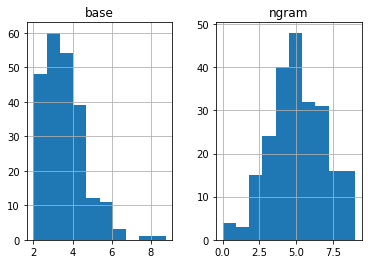

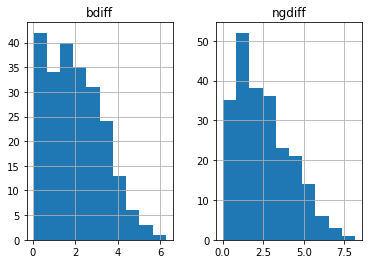

In [246]:
# how much better? And in which cases did it fail?
much_worse = common_sim[common_sim['bdiff'] < common_sim['ngdiff'] - 3]
print('largest/mean avg score where ngram model was outperformed by base model:', 
      much_worse['Average Score'].max(), '/', round(much_worse['Average Score'].mean(),2))

# but how is it distributed? might just be that the values are higher -> yes.
common_sim['base'] = np.minimum(common_sim['base'] + 2, 10)
pd.DataFrame.hist(common_sim, column=['base', 'ngram'])

# differences:
pd.DataFrame.hist(common_sim, column=['bdiff', 'ngdiff'])


#much_worse
